In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path, delimiter=','):
    """Load the CSV file with the correct delimiter and strip spaces from column names."""
    try:
        data = pd.read_csv(file_path, delimiter=delimiter)
        data.columns = data.columns.str.strip()
        return data
    except Exception as e:
        logging.error(f"Error loading data from {file_path}: {e}")
        raise

def filter_data(data):
    """Apply filtering conditions on the data."""
    filtered_data = data[(data['Score'] != 0 )]
    filtered_data = filtered_data[filtered_data['SEXO'].isin(['M', 'F'])]
    filtered_data = filtered_data[(filtered_data['Edad'] <= 90) & (filtered_data['Edad'] >= 18)]
    filtered_data = filtered_data[(filtered_data['INGRESO_CLIENTE'] <= 500000001) & (filtered_data['INGRESO_CLIENTE'] >= 1000000)]
    filtered_data = filtered_data[(filtered_data['Cant. Cuotas'] <= 24) & (filtered_data['Cant. Cuotas'] >= 1)]
    filtered_data = filtered_data[(filtered_data['Capital actual'] <= 30000000) & (filtered_data['Capital actual'] >= 300000)]
    filtered_data = filtered_data[(filtered_data['Valor Cuota'] <= 10000000) & (filtered_data['Valor Cuota'] >= 50000)]
    filtered_data = filtered_data[filtered_data['Banca'].isin([240, 420, 130, 471, 421, 470])]
    filtered_data = filtered_data[filtered_data['Tipo'].isin([201, 205, 300, 305, 200])]
    return filtered_data

def drop_columns(data, columns_to_drop):
    """Drop unnecessary columns from the data."""
    columns_to_drop = [col for col in columns_to_drop if col in data.columns]
    return data.drop(columns=columns_to_drop)

def preprocess_data(data, categorical_cols, numerical_cols, target_col):
    """Encode categorical variables, handle missing values, and scale numerical features."""
    data_encoded = pd.get_dummies(data, columns=categorical_cols)
    
    X = data_encoded.drop(columns=[target_col])
    y = data_encoded[target_col]
    
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    return X_scaled, y, imputer, scaler

In [2]:
import logging
import pandas as pd
from catboost import CatBoostClassifier
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    """Load the dataset from the specified file path."""
    return pd.read_csv(file_path)

def filter_data(data):
    """Apply any necessary data filtering here."""
    # Implement your data filtering logic
    return data

def drop_columns(data, columns):
    """Drop the specified columns from the dataset."""
    return data.drop(columns=columns, errors='ignore')

def preprocess_data(data, categorical_cols, numerical_cols, target_col):
    """Encode categorical variables, handle missing values, and scale numerical features."""
    # Encode categorical variables
    data_encoded = pd.get_dummies(data, columns=categorical_cols)

    # Check if target column is present
    if target_col not in data_encoded.columns:
        logging.error(f"Target column '{target_col}' not found in data columns: {data_encoded.columns}")
        raise KeyError(f"Target column '{target_col}' not found in data columns")

    X = data_encoded.drop(columns=[target_col])
    y = data_encoded[target_col]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y, imputer, scaler

def train_model(X, y):
    """Train the CatBoostClassifier with the specified parameters."""
    model = CatBoostClassifier(depth=5, iterations=400, l2_leaf_reg=3, learning_rate=0.06, random_seed=42, logging_level='Verbose')
    model.fit(X, y)
    return model

def save_model(model, imputer, scaler, model_path, imputer_path, scaler_path):
    """Save the trained model, imputer, and scaler to disk."""
    model.save_model(model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    logging.info("Model, imputer, and scaler saved successfully.")

def main():
    # File paths
    train_file_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/DropC(9M)Cond.csv'
    model_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/catboost_model.cbm'
    imputer_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/imputer.pkl'
    scaler_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/scaler.pkl'
    
    # Columns to drop
    columns_to_drop = ["Año de Fecha Cierre", "Fecha Cierre", "Fecha Colocacion", "Analista", "APORTA_IVA", "Aportaips",
                       "Atraso",  "CALIFICACION", 
                       "Capital Venta", "CIUDADLAB", "CLIENTEFORMAL", "CUENTA", "CUOTAS_PEND", "CUOTASPAGADAS", 
                         "EMPRESA_PUBLICA1_LAB", "EMPRESA_PUBLICA2_LAB", "EMPRESA1_LAB",
                       "EMPRESA2_LAB", "ESTADO_OPERACION", "Faja", "Fecha Venta", "FECHA_CANCELACION", "Franquicia",
                       "HABILITA_PROD1_BNF", "HABILITA_PROD2_BNF",   "MONTO_ANTERIOR",
                       "MONTODESEMBOLSADO", "OPEPARALELA", "Operacion", "OPERACIONIPS", "PATENTE_COMERCIAL",
                       "Saldo Capital", "Score", "SECTOR_ECONOMICO",  "Sucursal", "Sucursaltipo",
                       "Supervisor",   "Vendedor", "Atraso60", "Atraso90", "Atraso180", "Cateura"
]

    # Categorical and numerical columns
    categorical_cols = [ "Banca", "CALIFICACION_ANTERIOR",  
                        "MARCA",  "SEXO", "Tipo", "Departamento",  "Medio",  "Canal"]
    numerical_cols = ["Cant. Cuotas", "Capital actual", "Edad", "INGRESO_CLIENTE", "Valor Cuota"]
    
    target_col = 'Atraso30'

    # Load and preprocess data
    logging.info("Loading data...")
    train_data = load_data(train_file_path)
    logging.info(f"Columns in the dataset after loading: {train_data.columns.tolist()}")
    
    logging.info("Filtering data...")
    train_data = filter_data(train_data)
    
    logging.info("Dropping unnecessary columns...")
    train_data = drop_columns(train_data, columns_to_drop)
    logging.info(f"Columns in the dataset after dropping: {train_data.columns.tolist()}")
    
    logging.info("Preprocessing data...")
    X_train, y_train, imputer, scaler = preprocess_data(train_data, categorical_cols, numerical_cols, target_col)
    
    # Train the model
    logging.info("Training the model...")
    final_model = train_model(X_train, y_train)

    # Save the model, imputer, and scaler
    logging.info("Saving the model, imputer, and scaler...")
    save_model(final_model, imputer, scaler, model_path, imputer_path, scaler_path)

    logging.info("Model training completed and saved.")

if __name__ == "__main__":
    main()


2024-08-02 15:30:38,671 - INFO - Loading data...
2024-08-02 15:30:39,188 - INFO - Columns in the dataset after loading: ['Año de Fecha Cierre', 'Fecha Cierre', 'Fecha Colocacion', 'Analista', 'APORTA_IVA', 'Aportaips', 'Atraso', 'Banca', 'CALIFICACION', 'CALIFICACION_ANTERIOR', 'Canal', 'Cant. Cuotas', 'Capital actual', 'Capital Venta', 'CIUDADLAB', 'CLIENTEFORMAL', 'CUENTA', 'CUOTAS_PEND', 'CUOTASPAGADAS', 'Departamento', 'Edad', 'EMPRESA_PUBLICA1_LAB', 'EMPRESA_PUBLICA2_LAB', 'EMPRESA1_LAB', 'EMPRESA2_LAB', 'ESTADO_OPERACION', 'Faja', 'Fecha Venta', 'FECHA_CANCELACION', 'Franquicia', 'HABILITA_PROD1_BNF', 'HABILITA_PROD2_BNF', 'INGRESO_CLIENTE', 'MARCA', 'Medio', 'MONTO_ANTERIOR', 'MONTODESEMBOLSADO', 'OPEPARALELA', 'Operacion', 'OPERACIONIPS', 'PATENTE_COMERCIAL', 'Saldo Capital', 'Score', 'SECTOR_ECONOMICO', 'SEXO', 'Sucursal', 'Sucursaltipo', 'Supervisor', 'Tipo', 'Valor Cuota', 'Vendedor', 'Atraso30', 'Atraso60', 'Atraso90', 'Atraso180', 'Cateura']
2024-08-02 15:30:39,188 - INFO 

0:	learn: 0.6814868	total: 66.1ms	remaining: 26.4s
1:	learn: 0.6707485	total: 74.3ms	remaining: 14.8s
2:	learn: 0.6618454	total: 82.8ms	remaining: 11s
3:	learn: 0.6539879	total: 91.1ms	remaining: 9.02s
4:	learn: 0.6461354	total: 100ms	remaining: 7.92s
5:	learn: 0.6399373	total: 109ms	remaining: 7.16s
6:	learn: 0.6347194	total: 117ms	remaining: 6.56s
7:	learn: 0.6299673	total: 125ms	remaining: 6.13s
8:	learn: 0.6257796	total: 134ms	remaining: 5.81s
9:	learn: 0.6216016	total: 142ms	remaining: 5.55s
10:	learn: 0.6180232	total: 151ms	remaining: 5.34s
11:	learn: 0.6150153	total: 159ms	remaining: 5.15s
12:	learn: 0.6125039	total: 167ms	remaining: 4.98s
13:	learn: 0.6100144	total: 176ms	remaining: 4.85s
14:	learn: 0.6079545	total: 185ms	remaining: 4.76s
15:	learn: 0.6056092	total: 193ms	remaining: 4.64s
16:	learn: 0.6033650	total: 202ms	remaining: 4.56s
17:	learn: 0.6016517	total: 211ms	remaining: 4.47s
18:	learn: 0.6000242	total: 220ms	remaining: 4.41s
19:	learn: 0.5984648	total: 229ms	remai

2024-08-02 15:30:43,034 - INFO - Saving the model, imputer, and scaler...
2024-08-02 15:30:43,036 - INFO - Model, imputer, and scaler saved successfully.
2024-08-02 15:30:43,037 - INFO - Model training completed and saved.


386:	learn: 0.5587394	total: 3.16s	remaining: 106ms
387:	learn: 0.5587163	total: 3.17s	remaining: 98.1ms
388:	learn: 0.5586921	total: 3.18s	remaining: 89.9ms
389:	learn: 0.5586704	total: 3.19s	remaining: 81.7ms
390:	learn: 0.5586511	total: 3.19s	remaining: 73.5ms
391:	learn: 0.5586331	total: 3.2s	remaining: 65.3ms
392:	learn: 0.5586133	total: 3.21s	remaining: 57.2ms
393:	learn: 0.5585914	total: 3.22s	remaining: 49ms
394:	learn: 0.5585572	total: 3.22s	remaining: 40.8ms
395:	learn: 0.5585281	total: 3.23s	remaining: 32.6ms
396:	learn: 0.5584984	total: 3.24s	remaining: 24.5ms
397:	learn: 0.5584754	total: 3.25s	remaining: 16.3ms
398:	learn: 0.5584512	total: 3.25s	remaining: 8.16ms
399:	learn: 0.5584172	total: 3.26s	remaining: 0us


Accuracy: 0.6901054607696979
Confusion Matrix:
[[21106  2641]
 [ 8584  3891]]


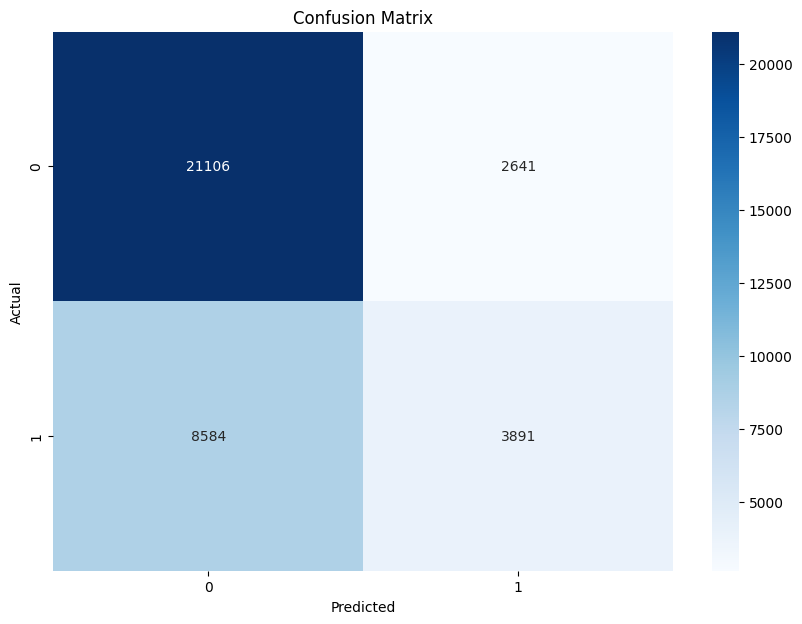

Predictions completed and saved.
   Operacion  Confidence
0   15022566  835.989275
1   15022573  524.931958
2   15022578  696.147481
3   15022582  736.474824
4   15022584  731.961126


In [3]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model, imputer, and scaler
model_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/catboost_model.cbm'
final_model = CatBoostClassifier()
final_model.load_model(model_path)

imputer = joblib.load('/Users/fabrizioferrari/Desktop/DATALAB V2/imputer.pkl')
scaler = joblib.load('/Users/fabrizioferrari/Desktop/DATALAB V2/scaler.pkl')

# Load the new CSV file for testing
test_file_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/DropC(3UM)Cond.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
test_data.columns = test_data.columns.str.strip()  # Strip spaces from column names

# Separate the 'Score' and 'Atraso30' columns
test_score_column = test_data['Score']
test_atraso30_column = test_data['Atraso30']
test_operacion_column = test_data['Operacion']

# Apply filtering conditions on the test data (ensure consistency with training data)
test_data = test_data[(test_data['Score'] != 0 )]
test_data = test_data[test_data['SEXO'].isin(['M', 'F'])]
test_data = test_data[(test_data['Edad'] <= 90) & (test_data['Edad'] >= 18)]
test_data = test_data[(test_data['INGRESO_CLIENTE'] <= 500000001) & (test_data['INGRESO_CLIENTE'] >= 1000000)]
test_data = test_data[(test_data['Cant. Cuotas'] <= 24) & (test_data['Cant. Cuotas'] >= 1)]
test_data = test_data[(test_data['Capital actual'] <= 30000000) & (test_data['Capital actual'] >= 300000)]
test_data = test_data[(test_data['Valor Cuota'] <= 10000000) & (test_data['Valor Cuota'] >= 50000)]
test_data = test_data[test_data['Banca'].isin([240, 420, 130, 471, 421, 470])]
test_data = test_data[test_data['Tipo'].isin([201, 205, 300, 305, 200])]

# Drop unnecessary columns from the test data
columns_to_drop = [
    "Año de Fecha Cierre", "Fecha Cierre", "Fecha Colocacion", "Analista", "APORTA_IVA", "Aportaips",
    "Atraso", "CALIFICACION", "Capital Venta", "CIUDADLAB", "CLIENTEFORMAL", "CUENTA", "CUOTAS_PEND", "CUOTASPAGADAS",
    "EMPRESA_PUBLICA1_LAB", "EMPRESA_PUBLICA2_LAB", "EMPRESA1_LAB", "EMPRESA2_LAB", "ESTADO_OPERACION", "Faja", 
    "Fecha Venta", "FECHA_CANCELACION", "Franquicia", "HABILITA_PROD1_BNF", "HABILITA_PROD2_BNF", "MONTO_ANTERIOR",
    "MONTODESEMBOLSADO", "OPEPARALELA", "Operacion", "OPERACIONIPS", "PATENTE_COMERCIAL", "Saldo Capital", "Score", 
    "SECTOR_ECONOMICO", "Sucursal", "Sucursaltipo", "Supervisor", "Vendedor", "Atraso30", "Atraso60", "Atraso90", 
    "Atraso180", "Cateura"
]

columns_to_drop = [col for col in columns_to_drop if col in test_data.columns]
test_data.drop(columns=columns_to_drop, inplace=True)

# Categorical columns
categorical_cols = [
    "Banca", "CALIFICACION_ANTERIOR", "MARCA", "SEXO", "Tipo", "Departamento", "Medio", "Canal"
]

categorical_cols = [col for col in categorical_cols if col in test_data.columns]

# Encode categorical variables in the test data
test_data_encoded = pd.get_dummies(test_data, columns=categorical_cols)

# Align the test data with the training data
missing_cols = set(imputer.feature_names_in_) - set(test_data_encoded.columns)
for col in missing_cols:
    test_data_encoded[col] = 0
test_data_encoded = test_data_encoded[imputer.feature_names_in_]

# Handle missing values in the test data
X_test_imputed = imputer.transform(test_data_encoded)

# Feature Scaling for the test data
X_test_scaled = scaler.transform(X_test_imputed)

# Make predictions on the test data
test_predictions = final_model.predict(X_test_scaled)

# Calculate the confidence scores
test_confidences = 1000 - final_model.predict_proba(X_test_scaled)[:, 1] * 1000  # Scale to 0-1000

# Align the length of test_score_column and test_atraso30_column with the filtered and processed test data
test_score_column = test_score_column.loc[test_data_encoded.index]
test_atraso30_column = test_atraso30_column.loc[test_data_encoded.index]
test_operacion_column = test_operacion_column.loc[test_data_encoded.index]

# Create a DataFrame with the test set actual and predicted values
results_df = pd.DataFrame({
    'Operacion': test_operacion_column,
    'Confidence': test_confidences
})

# Calculate accuracy
accuracy = accuracy_score(test_atraso30_column, test_predictions)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_atraso30_column, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the results DataFrame to a new CSV file
output_file_path = '/Users/fabrizioferrari/Desktop/DATALAB V2/new_predictions.csv'
results_df.to_csv(output_file_path, index=False)

print("Predictions completed and saved.")
print(results_df.head())
